In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [28]:
df = pd.read_csv('../content/S02-hw-dataset.csv',header=0).head(1000)
data = df.values

In [ ]:
print(df.head())

   user_id   age country  purchases  revenue
0        1  25.0      FR          7      749
1        2  24.0      RU          5     1115
2        3  52.0      FR          7      399
3        4  31.0      RU          6      654
4        5   NaN      DE          6     1296


In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB
None


In [30]:
print(df.describe())

         user_id         age  purchases      revenue
count  41.000000   39.000000  41.000000    41.000000
mean   20.243902   36.512821   4.829268   820.048780
std    11.659289   18.304259   2.710189   613.127269
min     1.000000    5.000000  -1.000000     0.000000
25%    10.000000   24.000000   3.000000   432.000000
50%    20.000000   33.000000   5.000000   693.000000
75%    30.000000   45.500000   7.000000  1115.000000
max    40.000000  120.000000  11.000000  2475.000000


In [36]:
missing_ratio = df.isna().mean()
duplicates = df.duplicated().sum()

suspect_negative = df[df["purchases"] < 0]
suspect_age = df[(df["age"] > 100) | (df["age"] < 5)]
suspect_rev = df[(df["revenue"] == 0) & (df["purchases"] > 0)]

suspicious = pd.concat([suspect_negative, suspect_age, suspect_rev]).drop_duplicates()

missing_ratio, duplicates, suspicious


(user_id      0.000000
 age          0.048780
 country      0.000000
 purchases    0.000000
 revenue      0.000000
 age_band     0.073171
 rev_group    0.097561
 age_group    0.073171
 dtype: float64,
 np.int64(1),
     user_id    age country  purchases  revenue     age_band rev_group  \
 5         6  120.0      FR         -1      785          NaN    medium   
 10       11   24.0      US          4        0  young_adult       NaN   
 
       age_group  
 5           NaN  
 10  young_adult  )

 Присутствуют пропуски возраста, а также полностью повторяющаяся строка с user_id = 10. Найдены аномалии: отрицательные покупки, возраст 120 и возраст 5, а также случаи, где выручка равна нулю при положительном количестве покупок.

In [49]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 18, 35, 60, 100],
    labels=["child/teen", "young_adult", "adult", "senior"]
)

In [50]:
df["country"].value_counts()


,count
country,
RU,13
FR,12
US,8
DE,6
CN,2


In [52]:
grouped = df.groupby("age_group").agg(
    avg_purchases=("purchases", "mean"),
    avg_revenue=("revenue", "mean"),
    total_rev=("revenue", "sum"),
    count_users=("user_id", "count")
)

grouped


/tmp/ipython-input-2593283453.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("age_group").agg(


,avg_purchases,avg_revenue,total_rev,count_users
age_group,,,,
child/teen,6.000000,1296.000000,2592,2
young_adult,4.952381,772.904762,16231,21
adult,4.533333,805.866667,12088,15
senior,NaN,NaN,0,0


In [53]:
df["revenue_band"] = pd.cut(
    df["revenue"],
    bins=[0, 300, 800, 1500, df["revenue"].max()],
    labels=["low", "medium", "high", "very_high"]
)

df["revenue_band"].value_counts()


,count
revenue_band,
medium,19
high,11
very_high,5
low,2


Доминируют категории young_adult и adult. У группы child/teen встречаются аномально высокие показатели выручки. Средняя выручка у adult выше, чем у young_adult. Категория senior почти отсутствует. Страны распределены неравномерно — чаще встречаются FR, RU и US.

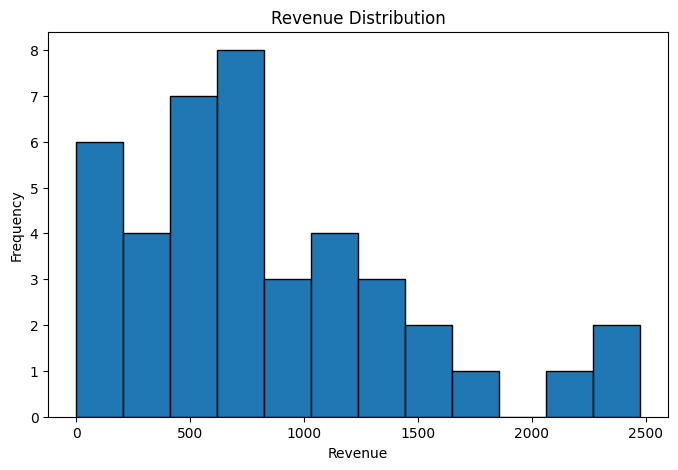

<Figure size 800x500 with 0 Axes>

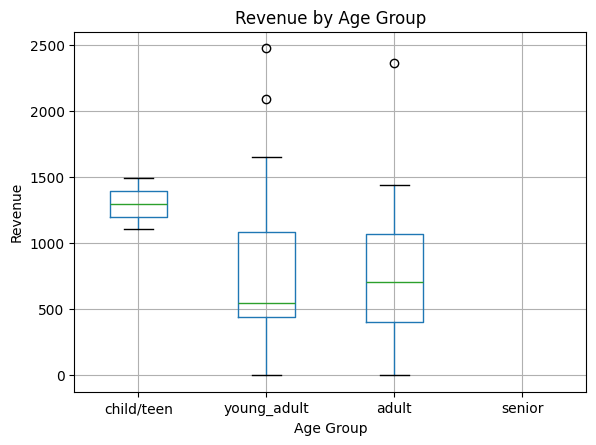

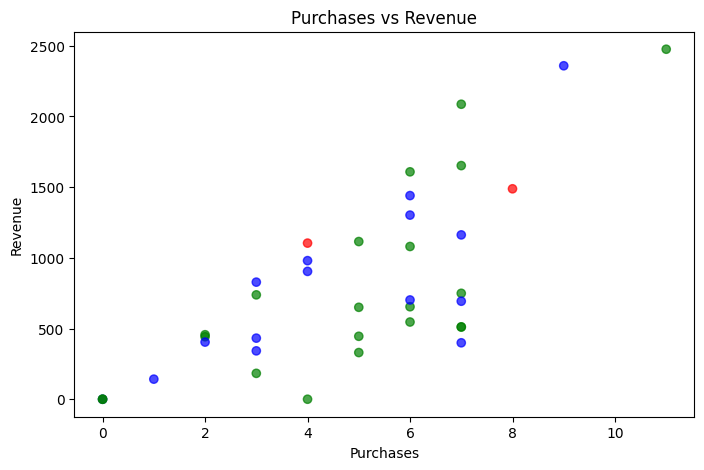

In [54]:
os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(8, 5))
plt.hist(df["revenue"], bins=12, edgecolor="black")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Revenue Distribution")
plt.savefig("figures/hist_revenue.png")
plt.show()
plt.figure(figsize=(8, 5))
df.boxplot(column="revenue", by="age_group")
plt.xlabel("Age Group")
plt.ylabel("Revenue")
plt.title("Revenue by Age Group")
plt.suptitle("")
plt.savefig("figures/boxplot_revenue_age.png")
plt.show()
colors = {
    "child/teen": "red",
    "young_adult": "green",
    "adult": "blue",
    "senior": "orange"
}

df_clean = df.dropna(subset=["age_group"]).copy()
df_clean["c"] = df_clean["age_group"].map(colors)

plt.figure(figsize=(8, 5))
plt.scatter(df_clean["purchases"], df_clean["revenue"], c=df_clean["c"], alpha=0.7)
plt.xlabel("Purchases")
plt.ylabel("Revenue")
plt.title("Purchases vs Revenue")
plt.savefig("figures/scatter_rev_purch.png")
plt.show()


Графики отражают данные и выводы, близкие к предыдущим, показывают аномалии и усреднённые значения. Сравнение двух основных групп по выручке выявляет общие тенденции,прослеживаются аномалии и сравнительная схожесть двух основных групп, с точки зрения выручки, в общем отношении, а график зависимости выручки от числа покупок указывает на недостаток данных для построения логических выводов, особенно в диапазоне 4–6 покупок.